In [1]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from tqdm.notebook import tqdm
from skbio.stats.distance import permanova
from scipy.spatial import distance
from scipy.linalg import khatri_rao
from skbio import DistanceMatrix
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

### functions

In [2]:
def plot_loadings(loadings, mf, 
                  mod_name, comp1, comp2, 
                  cat_of_interest, group_colors):
    
    t_load, s_load, f_load = loadings

    fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
    axn[0].plot(t_load[mod_name][['component_1', 
                                  'component_2', 
                                  'component_3']])
    axn[0].set_title('Temporal Loadings', fontsize=14)
    axn[0].legend(['PC1', 'PC2', 'PC3'])
    axn[1].scatter(s_load[mod_name][comp1],
                   s_load[mod_name][comp2],
                   #label=group_colors.keys(),
                   c=mf[cat_of_interest].map(group_colors))
    #axn[1].legend()
    axn[1].set_title('Individual Loadings', fontsize=14)
    axn[2].scatter(f_load[mod_name][comp1],
                   f_load[mod_name][comp2], c='black')
    axn[2].set_title('Feature Loadings', fontsize=14)
    plt.suptitle('Joint-CTF results ({})'.format(mod_name), 
                 fontsize=16, y=1.02)
    plt.setp(axn, xlabel=comp1.replace('_', ' '), 
                  ylabel=comp2.replace('_', ' '))
    plt.show()

def plot_feature_cov(tables, mod_cov, components,
                     sharey=True, axis_off=True):
    
    #get feature IDs for each modality
    feature_order = []
    for table in tables:
        feature_ids = table.ids(axis='observation').tolist()
        feature_order = feature_order + feature_ids

    n_comp = len(components)
    fig, axn = plt.subplots(1, n_comp, figsize=(5*n_comp, 4), 
                            sharey=sharey)

    for i, component in enumerate(components):
        cov_table = mod_cov[component]
        cov_table = cov_table.loc[feature_order, feature_order]
        #plot heatmap of feature covariance matrix
        sns.heatmap(cov_table, robust=True, cmap='vlag', 
                    center=0, ax=axn[i])
        axn[i].set_title('{}'.format(component))
    
    if axis_off:
        for ax in axn:
            ax.set_yticks([])
            ax.set_xticks([])

    plt.suptitle('Feature covariance', fontsize=16, y=1.02)
    plt.show()

def sub_feat_trajectory(table, feature_loadings, 
                        component, modality, zoom=True, 
                        quantile=0.95, pseudocount=0):
    # get the loadings
    floadings = feature_loadings[modality][component].copy()
    table_df = table.copy().to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass

    #drop any NaNs
    beta_l.dropna(inplace=True)

    return beta_l, top_fts, bottom_fts

def temporal_trajectory(individual_loadings, 
                        feature_loadings,
                        temporal_loadings, 
                        state_column, modality, 
                        component = 'component_1',
                        f_subset=True, quantile=0.95):
    #get loadings
    sloadings = individual_loadings[modality][[component]].copy()
    floadings = feature_loadings[modality][[component]].copy()
    t_index = temporal_loadings[modality]['time_interval']
    tloadings = temporal_loadings[modality][[component]].copy()
    #add dummy column to all loadings
    sloadings['dummy'] = 1
    floadings['dummy'] = 1
    tloadings['dummy'] = 1

    #calculate the column-wise khatri-rao products
    #subject trajectory
    s_traj = khatri_rao(sloadings, tloadings)
    s_traj = pd.DataFrame(s_traj, columns=[component,'dummy'])
    #add subject IDs and resolution
    a_indexes_repeated = np.repeat(sloadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, sloadings.shape[0])
    s_traj['subjectID'] = a_indexes_repeated
    s_traj[state_column] = c_indexes_tiled
    
    #feature trajectory
    if f_subset:
        #get top and bottom loading quantiles
        top_q = floadings[component].quantile(quantile)
        bottom_q = floadings[component].quantile(1-quantile)
        top_fts = floadings[floadings[component] >= top_q].index.tolist()
        bottom_fts = floadings[floadings[component] <= bottom_q].index.tolist()
        floadings = floadings.loc[top_fts+bottom_fts]
        f_traj = khatri_rao(floadings, tloadings)
    else:
        f_traj = khatri_rao(floadings, tloadings)
    
    f_traj = pd.DataFrame(f_traj, columns=[component,'dummy'])
    #add feature IDs and resolution
    b_indexes_repeated = np.repeat(floadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, floadings.shape[0])
    f_traj['featureID'] = b_indexes_repeated
    f_traj[state_column] = c_indexes_tiled
    #if top/bottom features used, label them accordingly
    if f_subset:
        f_traj['quantile'] = ['top_q' if x in top_fts else 'bottom_q' for x in f_traj.featureID]

    #remove dummy columns
    s_traj.drop(columns=['dummy'], inplace=True)
    f_traj.drop(columns=['dummy'], inplace=True)
    return s_traj, f_traj

### load and preprocess data

In [3]:
# load filtered tables
body_site = 'Baby-Feces'
baby_gut_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_gut_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Forearm'
baby_skin_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_skin_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Mouth'
baby_mouth_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_mouth_table = load_table('../data/%s/table-filtered.biom' % body_site)

In [4]:
#calculate sequencing depth in each table
baby_gut_df = baby_gut_table.to_dataframe()
baby_skin_df = baby_skin_table.to_dataframe()

#calculate the average count for each sample
gut_depth = baby_gut_df.sum(axis=0).sum()/baby_gut_df.shape[1]
skin_depth = baby_skin_df.sum(axis=0).sum()/baby_skin_df.shape[1]
print('Avg count in gut samples: %.2f' % gut_depth)
print('Avg count in skin samples: %.2f' % skin_depth)

Avg count in gut samples: 57830.48
Avg count in skin samples: 38653.87


In [5]:
#calculate the average count for each feature
gut_depth = baby_gut_df.sum(axis=0).sum()/baby_gut_df.shape[0]
skin_depth = baby_skin_df.sum(axis=0).sum()/baby_skin_df.shape[0]
print('Avg count in gut features: %.2f' % gut_depth)
print('Avg count in skin features: %.2f' % skin_depth)

Avg count in gut features: 21414.99
Avg count in skin features: 2511.26


In [6]:
#count how many unique IDs are in each birth mode
subject_id_column = 'subjectid_unique'
print(baby_gut_mf.shape)
print(baby_gut_mf.subjectid_unique.nunique())
print(baby_gut_mf.date_sampling_category_days_continuous.nunique())
print(baby_gut_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(1282, 48)
157
18
birth_mode_ms
CS        40
CSseed    24
Vag       93
Name: subjectid_unique, dtype: int64


In [7]:
#count how many unique IDs are in each birth mode
print(baby_skin_mf.shape)
print(baby_skin_mf.subjectid_unique.nunique())
print(baby_skin_mf.date_sampling_category_days_continuous.nunique())
print(baby_skin_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(747, 48)
90
18
birth_mode_ms
CS        17
CSseed    16
Vag       57
Name: subjectid_unique, dtype: int64


In [8]:
#count how many unique IDs are in each birth mode
print(baby_mouth_mf.shape)
print(baby_mouth_mf.subjectid_unique.nunique())
print(baby_mouth_mf.date_sampling_category_days_continuous.nunique())
print(baby_mouth_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(802, 48)
92
18
birth_mode_ms
CS        16
CSseed    21
Vag       55
Name: subjectid_unique, dtype: int64


In [9]:
vag_babies = baby_skin_mf[baby_skin_mf.birth_mode_ms == 'Vag']
cs_babies = baby_skin_mf[baby_skin_mf.birth_mode_ms == 'CS']
print("# samples")
print(vag_babies.shape)
print(cs_babies.shape)

print("Mean tps")
print(baby_skin_mf[subject_id_column].value_counts().mean())
print(vag_babies[subject_id_column].value_counts().mean())
print(cs_babies[subject_id_column].value_counts().mean())
print("Max tps")
print(baby_skin_mf[subject_id_column].value_counts().max())
print(vag_babies[subject_id_column].value_counts().max())
print(cs_babies[subject_id_column].value_counts().max())
print("Min tps")
print(baby_skin_mf[subject_id_column].value_counts().min())
print(vag_babies[subject_id_column].value_counts().min())
print(cs_babies[subject_id_column].value_counts().min())

# samples
(432, 48)
(180, 48)
Mean tps
8.3
7.578947368421052
10.588235294117647
Max tps
17
17
17
Min tps
2
2
5


### Joint-CTF with true data

In [10]:
# define temporary output directory
output_dir = '/Users/bec5786/Desktop/temp/beta_features/2mod/'
csseed = True
tps = '7-360'

if csseed:
    output_dir = '/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_true/'
else:
    output_dir = '/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/'

In [11]:
#(optional) subsetting
#define time splits
state_column = 'date_sampling_category_days_continuous'
splits_ = {'all':[0.0, 1.0, 2.0, 7.0, 14.0, 
                  21.0, 30.0, 60.0, 90.0, 120.0, 
                  150.0, 180.0, 210.0, 240.0, 
                  270.0, 300.0, 330.0, 360.0],
           '0-2':[0.0, 1.0, 2.0],
           '7-360':[7.0, 14.0, 30.0,
                    60, 120, 180, 360]}

if csseed == False:
    baby_gut_mf = baby_gut_mf[baby_gut_mf.birth_mode_ms != 'CSseed']
    baby_skin_mf = baby_skin_mf[baby_skin_mf.birth_mode_ms != 'CSseed']
    baby_mouth_mf = baby_mouth_mf[baby_mouth_mf.birth_mode_ms != 'CSseed']

# baby_gut_mf_120sub = baby_gut_mf[baby_gut_mf.date_sampling_category_days_continuous <= 120]
# baby_skin_mf_120sub = baby_skin_mf[baby_skin_mf.date_sampling_category_days_continuous <= 120]
# baby_mouth_mf_120sub = baby_mouth_mf[baby_mouth_mf.date_sampling_category_days_continuous <= 120]

baby_gut_mf_7_360 = baby_gut_mf[baby_gut_mf[state_column].isin(splits_['7-360'])]
baby_skin_mf_7_360 = baby_skin_mf[baby_skin_mf[state_column].isin(splits_['7-360'])]
baby_mouth_mf_7_360 = baby_mouth_mf[baby_mouth_mf[state_column].isin(splits_['7-360'])]

In [12]:
#pick the metadata to be used (original or subset)
if tps == 'all':
    mf1, mf2, mf3 = baby_gut_mf.copy(), baby_skin_mf.copy(), baby_mouth_mf.copy()
# elif tps == '120sub':
#     mf1, mf2, mf3 = baby_gut_mf_120sub.copy(), baby_skin_mf_120sub.copy(), baby_mouth_mf_120sub.copy()
elif tps == '7-360':
    mf1, mf2, mf3 = baby_gut_mf_7_360.copy(), baby_skin_mf_7_360.copy(), baby_mouth_mf_7_360.copy()

In [13]:
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep1 = mf1[subject_id_column].value_counts()[mf1[subject_id_column].value_counts() > 1].index
mf1 = mf1[mf1[subject_id_column].isin(ids_to_keep1)]

ids_to_keep2 = mf2[subject_id_column].value_counts()[mf2[subject_id_column].value_counts() > 1].index
mf2 = mf2[mf2[subject_id_column].isin(ids_to_keep2)]

ids_to_keep3 = mf3[subject_id_column].value_counts()[mf3[subject_id_column].value_counts() > 1].index
mf3 = mf3[mf3[subject_id_column].isin(ids_to_keep3)]

In [14]:
#ensure subjects are shared across modalities
shared_subjects = [s_id for s_id in mf1.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
print("# shared subjects: {}".format(len(shared_subjects)))
mf1 = mf1[mf1.subjectid_unique.isin(shared_subjects)]
mf2 = mf2[mf2.subjectid_unique.isin(shared_subjects)]
#sanity check
print(len(mf1.subjectid_unique.unique()))
print(len(mf2.subjectid_unique.unique()))

# shared subjects: 86
86
86


In [15]:
#subset tables prior to transformation
table1 = baby_gut_table.copy().filter(mf1.index, axis='sample')
table2 = baby_skin_table.copy().filter(mf2.index, axis='sample')
table3 = baby_mouth_table.copy().filter(mf3.index, axis='sample')

table1 = clr_transformation(table1.copy(), pseudocount=0.5)
table2 = clr_transformation(table2.copy(), pseudocount=0.5)
table3 = clr_transformation(table3.copy(), pseudocount=0.5)

In [16]:
ctf_results = joint_ctf(tables=[table1, table2],
                        sample_metadatas=[mf1, mf2],
                        modality_ids=['16S.1','16S.2'],
                        individual_id_column='subjectid_unique',
                        state_column='date_sampling_category_days_continuous')

(individual_loadings, feature_loadings, state_loadings, 
 eigenvalues, prop_explained, feature_covs) = ctf_results

Calculate components for component_1
Reached convergence in 14 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 21 iterations


In [17]:
comp1 = 'component_1'
comp2 = 'component_2'
cat_of_interest = 'birth_mode_ms'
state_column = 'date_sampling_category_days_continuous'
baby_combined_mf = pd.concat([mf1, mf2])
mf_all = baby_combined_mf.groupby('subjectid_unique').agg({cat_of_interest:'first'})

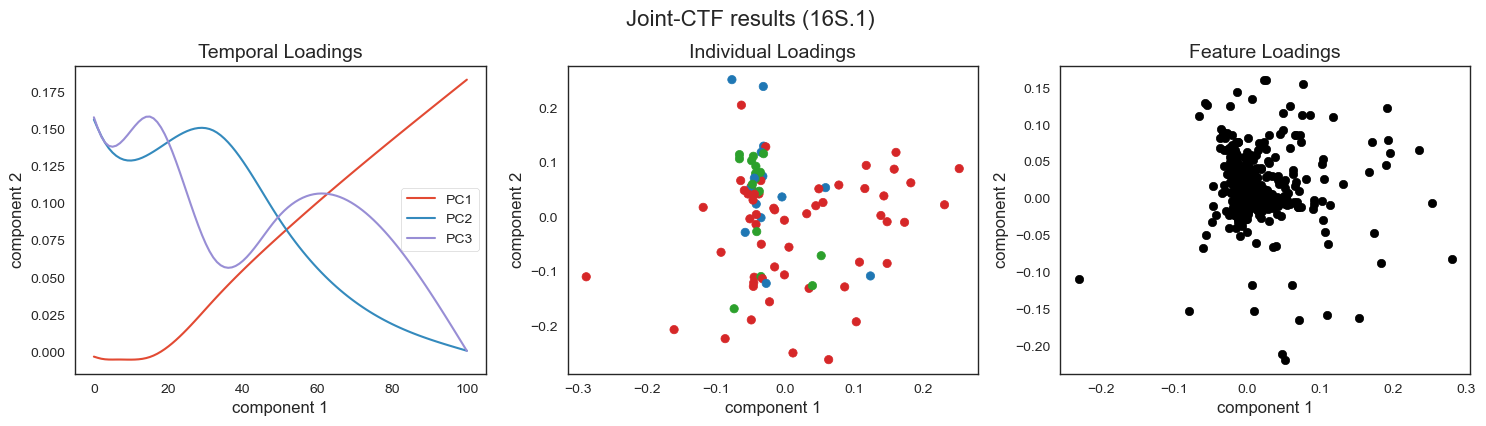

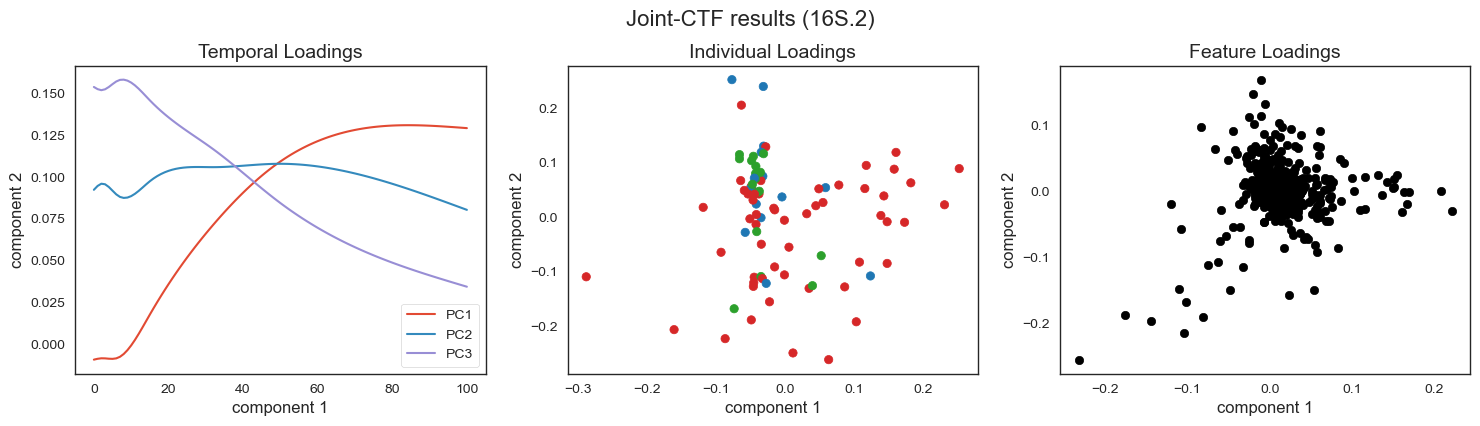

In [18]:
group_colors = {'CS': 'tab:blue', 'CSseed': 'tab:green', 'Vag': 'tab:red'}

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.1', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.2', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

In [19]:
print(eigenvalues)
print(prop_explained.T)

       component_1  component_2  component_3
16S.1  3020.065386   396.257321   262.228790
16S.2  4797.896765   450.869401   371.484623
               component_1  component_2  component_3
var_explained     0.826481     0.112602     0.060917


/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


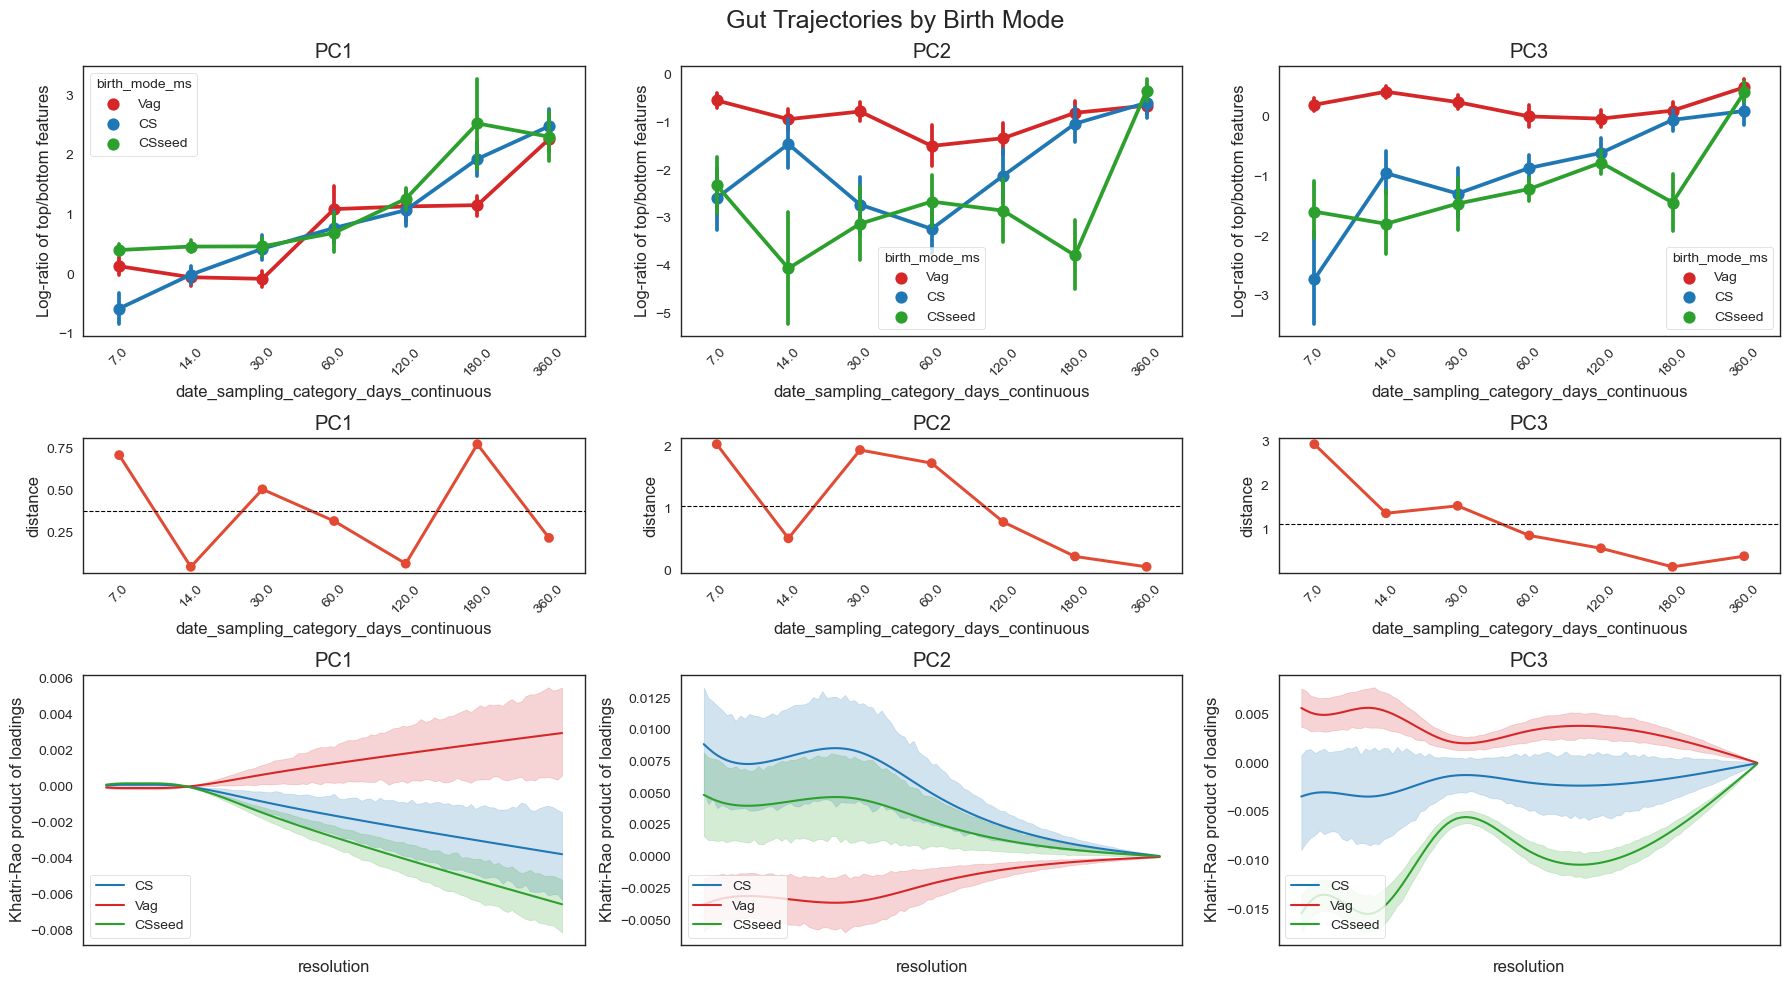

In [20]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile=0.95

#individual_loadings, feature_loadings, state_loadings
fig, axn = plt.subplots(3, 3, figsize=(18, 10), gridspec_kw = {'height_ratios':[6,3,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table1, feature_loadings, component=component,
                                                      modality='16S.1', pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    q_text = int(100*(1 - quantile))
    pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}Gut_top{}_features_PC{}_{}.txt'.format(output_dir, q_text, i+1, tps), 
                                                        sep='\t', index=False)
    pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}Gut_bottom{}_features_PC{}_{}.txt'.format(output_dir, q_text, i+1, tps), 
                                                           sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory_gut, ftrajectory_gut = temporal_trajectory(individual_loadings, feature_loadings,
                                                           state_loadings, modality='16S.1',
                                                           state_column='resolution',
                                                           component=component,
                                                           f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory_gut[cat_of_interest] = strajectory_gut['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory_gut, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('Gut Trajectories by Birth Mode', fontsize=18)
plt.tight_layout()
plt.show()

/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


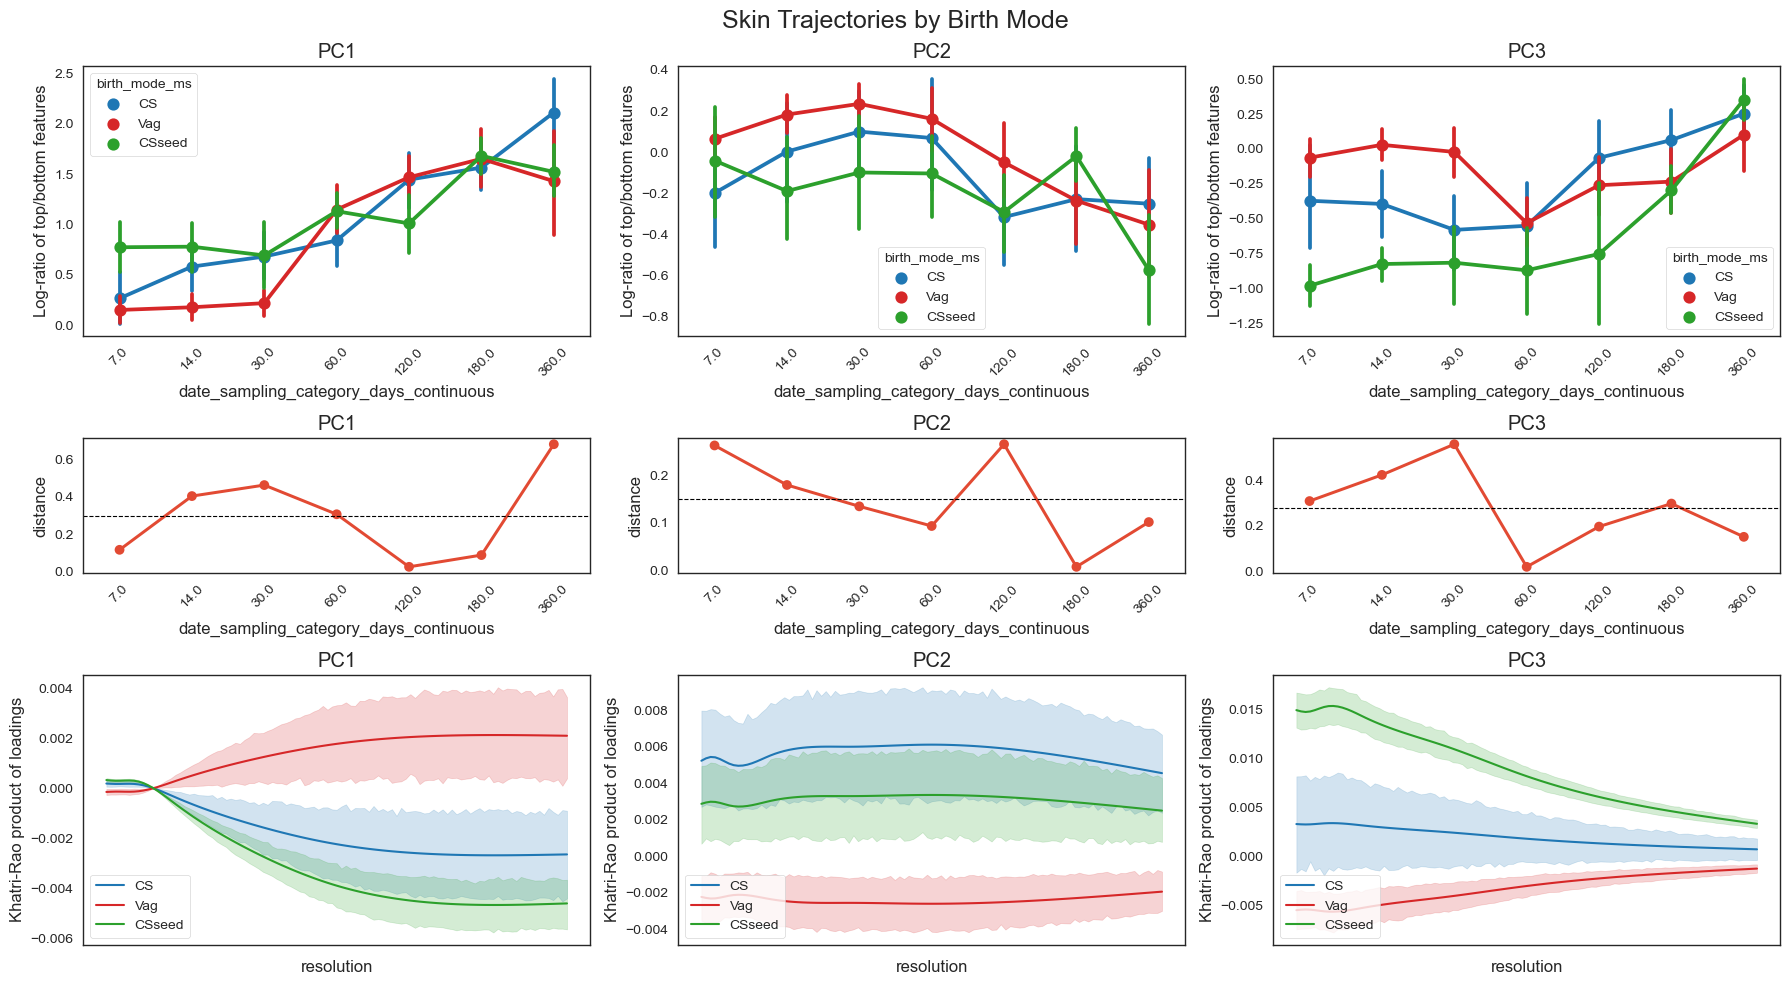

In [21]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile=0.95

fig, axn = plt.subplots(3, 3, figsize=(18, 10), gridspec_kw = {'height_ratios':[6,3,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table2.copy(), feature_loadings, component=component,
                                                      modality='16S.2', pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    q_text = int(100*(1 - quantile))
    pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}Skin_top{}_features_PC{}_{}.txt'.format(output_dir, q_text, i+1, tps), 
                                                        sep='\t', index=False)
    pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}Skin_bottom{}_features_PC{}_{}.txt'.format(output_dir, q_text, i+1, tps), 
                                                           sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory_gut, ftrajectory_gut = temporal_trajectory(individual_loadings, feature_loadings,
                                                           state_loadings, modality='16S.2',
                                                           state_column='resolution',
                                                           component=component,
                                                           f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory_gut[cat_of_interest] = strajectory_gut['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory_gut, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('Skin Trajectories by Birth Mode', fontsize=18)
plt.tight_layout()
plt.show()

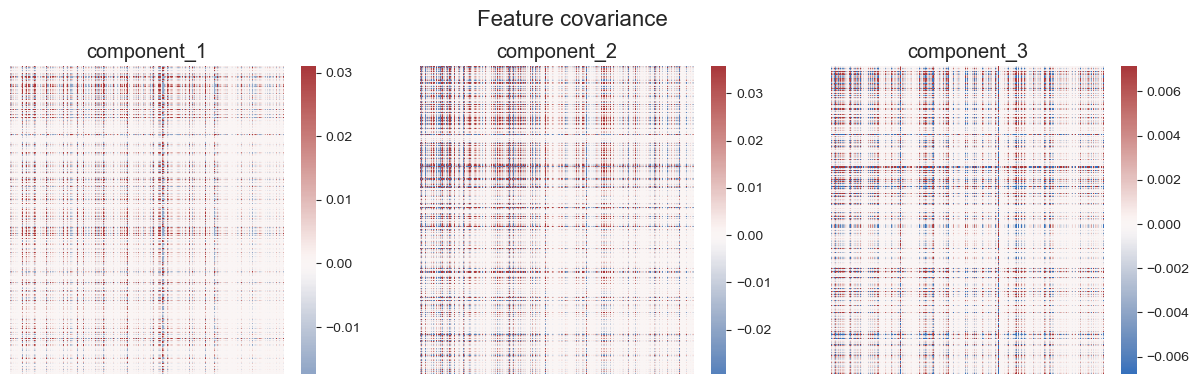

In [22]:
#plot covariance of a subset of features
plot_feature_cov(tables=[table1, table2], mod_cov=feature_covs, 
                 components=['component_1', 'component_2', 'component_3'])

In [33]:
##compare top features in one-mod vs two-mod decomposition
#load one-mod decomposition
top5_gut_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Gut_top5_features_PC1_all.txt', sep='\t')
print('top5_gut_individual:', top5_gut_individual_pc1.shape)
top5_skin_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Skin_top5_features_PC1_all.txt', sep='\t')
print('top5_skin_individual:', top5_skin_individual_pc1.shape)
#load two-mod decomposition
top5_gut_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Gut_top5_features_PC1_all.txt', sep='\t')
print('top5_gut_joint:', top5_gut_joint_pc1.shape)
top5_skin_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Skin_top5_features_PC1_all.txt', sep='\t')
print('top5_skin_joint:', top5_skin_joint_pc1.shape)

top5_gut_individual: (27, 1)
top5_skin_individual: (64, 1)
top5_gut_joint: (27, 1)
top5_skin_joint: (64, 1)


In [44]:
#repeat for bottom 5% features
#load one-mod decomposition
bottom5_gut_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Gut_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_gut_individual:', bottom5_gut_individual_pc1.shape)
bottom5_skin_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Skin_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_skin_individual:', bottom5_skin_individual_pc1.shape)
#load two-mod decomposition
bottom5_gut_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Gut_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_gut_joint:', bottom5_gut_joint_pc1.shape)
bottom5_skin_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Skin_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_skin_joint:', bottom5_skin_joint_pc1.shape)

bottom5_gut_individual: (27, 1)
bottom5_skin_individual: (64, 1)
bottom5_gut_joint: (27, 1)
bottom5_skin_joint: (64, 1)


In [46]:
#calculate intersection of top features
print("Top 5% features:")
gut_shared = set(top5_gut_individual_pc1.featureID).intersection(top5_gut_joint_pc1.featureID)
skin_shared = set(top5_skin_individual_pc1.featureID).intersection(top5_skin_joint_pc1.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

print("Bottom 5% features:")
gut_shared = set(bottom5_gut_individual_pc1.featureID).intersection(bottom5_gut_joint_pc1.featureID)
skin_shared = set(bottom5_skin_individual_pc1.featureID).intersection(bottom5_skin_joint_pc1.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

Top 5% features:
# shared gut features: 0
# shared skin features: 63
Bottom 5% features:
# shared gut features: 0
# shared skin features: 61


In [47]:
gut_shared = set(top5_gut_individual_pc1.featureID).intersection(bottom5_gut_joint_pc1.featureID)
skin_shared = set(top5_skin_individual_pc1.featureID).intersection(bottom5_skin_joint_pc1.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

# shared gut features: 13
# shared skin features: 0


In [34]:
##compare top features in one-mod vs two-mod decomposition
#load one-mod decomposition
top5_gut_individual_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Gut_top5_features_PC2_all.txt', sep='\t')
print('top5_gut_individual:', top5_gut_individual_pc2.shape)
top5_skin_individual_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Skin_top5_features_PC2_all.txt', sep='\t')
print('top5_skin_individual:', top5_skin_individual_pc2.shape)
#load two-mod decomposition
top5_gut_joint_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Gut_top5_features_PC2_all.txt', sep='\t')
print('top5_gut_joint:', top5_gut_joint_pc2.shape)
top5_skin_joint_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Skin_top5_features_PC2_all.txt', sep='\t')
print('top5_skin_joint:', top5_skin_joint_pc2.shape)

top5_gut_individual: (27, 1)
top5_skin_individual: (64, 1)
top5_gut_joint: (27, 1)
top5_skin_joint: (64, 1)


In [42]:
print(len(set(top5_skin_individual_pc1.featureID).intersection(top5_skin_individual_pc2.featureID)))
print(len(set(top5_gut_individual_pc1.featureID).intersection(top5_gut_individual_pc2.featureID)))

16
7


In [43]:
print(len(set(top5_gut_individual_pc1.featureID).intersection(top5_gut_joint_pc2.featureID)))
print(len(set(top5_gut_individual_pc2.featureID).intersection(top5_gut_joint_pc1.featureID)))

11
5


In [38]:
#calculate intersection of top features
gut_shared_pc2 = set(top5_gut_individual_pc2.featureID).intersection(top5_gut_joint_pc2.featureID)
skin_shared_pc2 = set(top5_skin_individual_pc2.featureID).intersection(top5_skin_joint_pc2.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

# shared gut features: 0
# shared skin features: 63


### Data-driven simulations

Placeholder code below

In [23]:
stop
# inits
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
experiment = 'seq-depth'
# import simulations from file
file_lst = glob.glob('../results/{}-tables/*.biom'.format(experiment))

simulations_depth = {(tbl_.split('/')[-1].split('-')[0],
                      int(tbl_.split('/')[-1].split('-')[2]),
                      int(tbl_.split('/')[-1].split('-')[3].split('.')[0])):load_table(tbl_)
                      for tbl_ in file_lst if len(tbl_.split('/')[-1].split('-')) == 4}
simulations_depth.keys()

NameError: name 'stop' is not defined

In [ ]:
simulation_results = {}
fold = 0
depth = 5000
mf_dict = {'gut':baby_gut_mf, 'skin':baby_skin_mf, 'mouth':baby_mouth_mf}

for k_sim in tqdm([('gut','skin'), ('gut','mouth'), ('mouth','skin')]):
    print(k_sim)
    # prepare tables
    site1 = k_sim[0]
    site2 = k_sim[1]
    table1 = simulations_depth[(site1, depth, fold)].copy()
    table1 = clr_transformation(table1, pseudocount=0.5)
    table2 = simulations_depth[(site2, depth, fold)].copy()
    table2 = clr_transformation(table2, pseudocount=0.5)
    # prepare metadata
    mf1 = mf_dict[site1].copy()
    mf2 = mf_dict[site2].copy()
    # run joint-ctf
    sites = '{}-{}'.format(site1, site2)
    simulation_results[(sites, depth, fold)] = joint_ctf(tables=[table1, table2],
                                                         sample_metadatas=[mf1, mf2],
                                                         modality_ids=['16S.1','16S.2'],
                                                         individual_id_column='subjectid_unique',
                                                         state_column='date_sampling_category_days_continuous')

In [ ]:
##sim_results = subject_loads, feature_loads, state_loads, subject_lambdas, var_explained, feature_covs
cat_of_interest = 'birth_mode_ms'
permanova_results = {}

for k_sim, (ind_loads, _, _, _, _, _) in tqdm(simulation_results.items()):
    
    ind_loads = ind_loads['16S.1']
    mf_tmp = mf.copy()
    mf_tmp.index = mf_tmp.subjectid_unique
    mf_tmp = mf_tmp.loc[ind_loads.index, :]
    
    for t_, t_mf in mf_tmp.groupby(state_column):
        # calculate distance for subjects
        dists = distance.cdist(ind_loads.values, ind_loads.values)
        dists = DistanceMatrix(dists, ids=ind_loads.index)
        dists.ids = list(map(str, dists.ids))
        dist_tmp_t = dists.copy().filter(t_mf.index)
        # MAKE SURE IT IS ORDERED CORRECTLY!
        t_mf = t_mf.reindex(dist_tmp_t.ids)
        permanova_results[(k_sim[0], k_sim[1], t_)] = permanova(dist_tmp_t, 
                                                                t_mf[cat_of_interest])
        # permanova_results[(k_sim[0], k_sim[1], 
        #                    k_sim[2], t_)] = permanova(dist_tmp_t, t_mf[cat_of_interest])

permanova_results_df = pd.DataFrame(permanova_results).T.reset_index()
permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                    'level_1':'simulation_fold',
                                                    'level_2':state_column}, axis=1)
# permanova_results_df = permanova_results_df.rename({'level_0':'depth',
#                                                     'level_1':'dispersion',
#                                                     'level_2':'simulation_fold',
#                                                     'level_3':state_column}, axis=1)
permanova_results_df['depth'] = permanova_results_df['depth'].astype(int)
#permanova_results_df['dispersion'] = permanova_results_df['dispersion'].astype(int)
permanova_results_df.head(3)

In [ ]:
fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
test = 'depth'
sns.barplot(x=test, y='test statistic', data=permanova_results_df, 
            ci=68, ax=axn[0])
axn[0].set_facecolor('white')
axn[0].set_xlabel(test)
sns.pointplot(x=state_column, hue=test, y='test statistic', 
              data=permanova_results_df, ci=68, ax=axn[1])
axn[1].set_facecolor('white')
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.set_style('white')
mods = ['16S.1', '16S.2']
#depth = 1000
for fold_ in [1]:

    print('Fold {}'.format(fold_))
    cols = sorted(set([int(k[0]) for k in simulation_results.keys()]))
    rows = mods
    fig, axn = plt.subplots(len(rows)+1, len(cols), figsize=(10, 10))
    mf_subject_collapsed = mf.groupby(subject_id_column).agg({cat_of_interest:'first'})
    group_colors = {'Vag': 'tab:red', 'CSseed': 'tab:blue', 'CS': 'tab:green'}
    comp1 = 'component_1'
    comp2 = 'component_2'

    for i, exp in enumerate(cols):
        ind_loads, _, state_loads, _, _, _ = simulation_results[(exp, fold_)]
        #ind_loads, _, state_loads, _, _, _ = simulation_results[(depth, exp, fold_)]
        sns.scatterplot(x=ind_loads['16S.1'][comp1], 
                        y=ind_loads['16S.1'][comp2],  
                        hue=mf_subject_collapsed[cat_of_interest], 
                        palette=group_colors, ax=axn[0,i])
        axn[0,i].set_title(exp)

        sns.lineplot(data=state_loads['16S.1'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[1,i], dashes=False)
        axn[1,i].set_title('Mod1, depth = {}'.format(exp))
        axn[1,i].legend() 
        axn[1,i].set_xlabel('resolution')         
        axn[1,i].set_ylabel('loadings') 
        sns.lineplot(data=state_loads['16S.2'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[2,i], dashes=False)
        axn[2,i].set_title('Mod2, depth = {}'.format(exp))
        axn[2,i].legend() 
        axn[2,i].set_xlabel('resolution')         
        axn[2,i].set_ylabel('loadings') 

    plt.tight_layout()
    plt.show()